In [1]:
import bw2data as bd
from datetime import datetime

# bd.projects.set_current("optimex_demo")
# bd.databases

/Users/timodiepers/anaconda3/envs/optimex/lib/python3.11/site-packages/scikits/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__('pkg_resources').declare_namespace(__name__)


In [2]:
bd.projects.set_current("timex")
bd.databases

Databases dictionary with 8 object(s):
	Mobility example
	ecoinvent-3.10-biosphere
	ecoinvent-3.10-cutoff
	ei310_IMAGE_SSP2_RCP19_2020_electricity
	ei310_IMAGE_SSP2_RCP19_2030_electricity
	ei310_IMAGE_SSP2_RCP19_2040_electricity
	foreground
	test_small

In [3]:
db_bio = bd.Database("ecoinvent-3.10-biosphere") 

# Create a dict of databases keyed by year
dbs = {
    2020: bd.Database("ei310_IMAGE_SSP2_RCP19_2020_electricity"),
    # 2030: bd.Database("ei310-SSP2-RCP19-2030"),
    2030: bd.Database("ei310_IMAGE_SSP2_RCP19_2030_electricity"),
    2040: bd.Database("ei310_IMAGE_SSP2_RCP19_2040_electricity"),
}

# Add representative_time metadata for each database
for year, db in dbs.items():
    db.metadata["representative_time"] = datetime(year, 1, 1).isoformat()

eidb = bd.Database("ecoinvent-3.10-cutoff")
db_2020 =dbs[2020]

if "foreground" in bd.databases:
    del bd.databases["foreground"] # to make sure we create the foreground from scratch
foreground = bd.Database("foreground")
foreground.write({})
foreground.register()

In [4]:
from collections import namedtuple
import numpy as np
import bw_temporalis as bwt

# === Define reusable structure for flow data ===
Flow = namedtuple("Flow", ["dataset", "amount", "type", "phase"])

# === Phase durations ===
timing_config = {
    "PEM_Electrolysis": {
        "construction": 2,
        "lifetime": 10,
        "decommissioning": 1,
    },
    "SMR": {
        "construction": 3,
        "lifetime": 15,
        "decommissioning": 2,
    }
}

# === Temporal distribution generators ===
def make_temporal_distributions(name):
    config = timing_config[name]
    c, l, d = config["construction"], config["lifetime"], config["decommissioning"]

    return {
        "pre_operation": lambda: bwt.easy_timedelta_distribution(
            start=0, end=c, resolution="Y", steps=c + 1,
            kind="triangular" if name == "SMR" else "uniform"
        ),
        "operation": lambda: bwt.easy_timedelta_distribution(
            start=c, end=c + l, resolution="Y", steps=l + 1, kind="uniform"
        ),
        "post_operation": lambda: bwt.TemporalDistribution(
            date=np.array([c + l + d], dtype="timedelta64[Y]"),
            amount=np.array([1])
        )
    }

temporal_distributions = {
    name: make_temporal_distributions(name)
    for name in timing_config
}

In [5]:

# === Important flows for PEM and SMR ===
important_flows_pem = {
    "h2_pem": Flow(db_2020.get(name="hydrogen production, gaseous, 30 bar, from PEM electrolysis, from grid electricity", unit="kilogram"), 1.0, "production", "operation"),
    "electrolyzer_stack": Flow(db_2020.get(name="electrolyzer production, 1MWe, PEM, Stack"), 1.35e-6, "technosphere", "pre_operation"),
    "electrolyzer_bop": Flow(db_2020.get(name="electrolyzer production, 1MWe, PEM, Balance of Plant"), 3.37e-7, "technosphere", "pre_operation"),
    "electrolyzer_disposal_stack": Flow(db_2020.get(name="treatment of fuel cell stack, 1MWe, PEM"), -1.35e-6, "technosphere", "post_operation"),
    "electrolyzer_disposal_bop": Flow(db_2020.get(name="treatment of fuel cell balance of plant, 1MWe, PEM"), -3.37e-7, "technosphere", "post_operation"),
    "electricity": Flow(db_2020.get(name="market group for electricity, low voltage", location="WEU"), 54.0, "technosphere", "operation"),
    "water_deionised_europe": Flow(db_2020.get(name="market for water, deionised", location="Europe without Switzerland"), 14.0, "technosphere", "operation"),
    "oxygen_air": Flow(db_bio.get(name="Oxygen", categories=("air",)), 8.0, "biosphere", "operation"),
}

important_flows_smr = {
    "h2_smr": Flow(db_2020.get(name="hydrogen production, steam methane reforming", location="RER", unit="kilogram"), 1.0, "production", "operation"),
    "natural_gas_ch": Flow(db_2020.get(name="market for natural gas, high pressure", location="CH"), 0.0294, "technosphere", "operation"),
    "natural_gas_europe": Flow(db_2020.get(name="market group for natural gas, high pressure", location="Europe without Switzerland"), 4.22, "technosphere", "operation"),
    "chemical_factory_construction": Flow(db_2020.get(name="chemical factory construction, organics", location="RER"), 4.99e-10, "technosphere", "pre_operation"),
    "water_deionised_ch": Flow(db_2020.get(name="market for water, deionised", location="CH"), 0.0148, "technosphere", "operation"),
    "water_deionised_europe": Flow(db_2020.get(name="market for water, deionised", location="Europe without Switzerland"), 4.12, "technosphere", "operation"),
    "oxygen_air": Flow(db_bio.get(name="Oxygen", categories=("natural resource", "in air")), 6.07, "biosphere", "operation"),
    "cooling_water": Flow(db_bio.get(name="Water, cooling, unspecified natural origin", categories=("natural resource", "in water")), 0.355, "biosphere", "operation"),
    "co2_fossil": Flow(db_bio.get(name="Carbon dioxide, fossil", categories=("air",)), 8.35, "biosphere", "operation"),
}

In [6]:
nodes = [n for d in (important_flows_pem, important_flows_smr) for n, *_ in d.values()]

In [7]:
for node in nodes:
    if node["database"] == db_bio.name:
        continue
    for db in dbs.values():
        node_in_other_db = db.get(
            name=node["name"],
            product=node["reference product"],
            location=node["location"],
        )
        if node["code"] != node_in_other_db["code"]:
            node_in_other_db["code"] = node["code"]
            node_in_other_db.save()

In [8]:

# === Exchange generation function ===
def flow_dict_to_exchanges(flow_dict, process_type, activity_key):
    exchanges = []
    td = temporal_distributions[process_type]

    for _, flow in flow_dict.items():
        exchange = {
            "amount": flow.amount,
            "type": flow.type,
            "input": activity_key if flow.type == "production" else flow.dataset.key,
            "unit": flow.dataset["unit"],
            "temporal_distribution": td[flow.phase](),
            "operation": flow.phase == "operation",
        }
        exchanges.append(exchange)

    return exchanges

# === Define foreground activities ===
pem_key = ("foreground", "hydrogen_production_pem")
smr_key = ("foreground", "hydrogen_production_smr")

pem_activity = {
    pem_key: {
        "name": "Hydrogen via PEM electrolysis",
        "unit": "kilogram",
        "location": "RER",
        "reference product": "hydrogen",
        "exchanges": flow_dict_to_exchanges(important_flows_pem, "PEM_Electrolysis", pem_key),
        "operation_time_limits": (2,2+10),
    }
}

smr_activity = {
    smr_key: {
        "name": "Hydrogen via Steam Methane Reforming",
        "unit": "kilogram",
        "location": "RER",
        "reference product": "hydrogen",
        "exchanges": flow_dict_to_exchanges(important_flows_smr, "SMR", smr_key),
        "operation_time_limits": (3,3+15),
    }
}

# === Write to foreground database ===
foreground.write({**pem_activity, **smr_activity})
foreground.register()


13:00:21+0200 [warning  ] Not able to determine geocollections for all datasets. This database is not ready for regionalization.


100%|██████████| 2/2 [00:00<00:00, 4194.30it/s]

13:00:21+0200 [info     ] Vacuuming database            


In [9]:
flow_dict_to_exchanges(important_flows_pem, "PEM_Electrolysis", pem_key)

[{'amount': 1.0,
  'type': 'production',
  'input': ('foreground', 'hydrogen_production_pem'),
  'unit': 'kilogram',
  'temporal_distribution': TemporalDistribution instance with 11 values and total: 1,
  'operation': True},
 {'amount': 1.35e-06,
  'type': 'technosphere',
  'input': ('ei310_IMAGE_SSP2_RCP19_2020_electricity',
   'a2aefcfee19f4dc19a7a3676b4757def'),
  'unit': 'unit',
  'temporal_distribution': TemporalDistribution instance with 3 values and total: 1,
  'operation': False},
 {'amount': 3.37e-07,
  'type': 'technosphere',
  'input': ('ei310_IMAGE_SSP2_RCP19_2020_electricity',
   'ac9df8226b864ca188cb2442c8c1d5fb'),
  'unit': 'unit',
  'temporal_distribution': TemporalDistribution instance with 3 values and total: 1,
  'operation': False},
 {'amount': -1.35e-06,
  'type': 'technosphere',
  'input': ('ei310_IMAGE_SSP2_RCP19_2020_electricity',
   '490a7122aaa4451191641d80ee802e6b'),
  'unit': 'unit',
  'temporal_distribution': TemporalDistribution instance with 1 values and 

In [10]:
smr = foreground.get(name="Hydrogen via Steam Methane Reforming")
for exc in smr.exchanges():
    print(exc)

Exchange: 1.0 kilogram 'Hydrogen via Steam Methane Reforming' (kilogram, RER, None) to 'Hydrogen via Steam Methane Reforming' (kilogram, RER, None)>
Exchange: 0.0294 cubic meter 'market for natural gas, high pressure' (cubic meter, CH, None) to 'Hydrogen via Steam Methane Reforming' (kilogram, RER, None)>
Exchange: 4.22 cubic meter 'market group for natural gas, high pressure' (cubic meter, Europe without Switzerland, None) to 'Hydrogen via Steam Methane Reforming' (kilogram, RER, None)>
Exchange: 4.99e-10 unit 'chemical factory construction, organics' (unit, RER, None) to 'Hydrogen via Steam Methane Reforming' (kilogram, RER, None)>
Exchange: 0.0148 kilogram 'market for water, deionised' (kilogram, CH, None) to 'Hydrogen via Steam Methane Reforming' (kilogram, RER, None)>
Exchange: 4.12 kilogram 'market for water, deionised' (kilogram, Europe without Switzerland, None) to 'Hydrogen via Steam Methane Reforming' (kilogram, RER, None)>
Exchange: 6.07 kilogram 'Oxygen' (kilogram, None, ('

In [11]:
from datetime import datetime
method = ('EF v3.1 no LT',
  'climate change no LT',
  'global warming potential (GWP100) no LT')

# Define temporally distributed demand from 2025 to 2045
years = range(2020, 2100)
td_demand = bwt.TemporalDistribution(
    date=np.array([datetime(year, 1, 1).isoformat() for year in years], dtype='datetime64[s]'),
    amount=np.asarray([10000] * len(years), dtype=float)  # 100 kg per year
)

In [12]:
from optimex import lca_processor

lca_config = lca_processor.LCAConfig(
    demand={"hydrogen": td_demand},
    temporal={
        "start_date": datetime(2020, 1, 1),
        "temporal_resolution": "year",
        "time_horizon": 100,
    },
    characterization_methods=[
        {
            "category_name": "climate_change",
            "brightway_method": method,
            "metric": "GWP", # CRF
        },
        {
            "category_name": "resource_depletion",
            "brightway_method": (
                "EF v3.1 no LT",
                "material resources: metals/minerals no LT",
                "abiotic depletion potential (ADP): elements (ultimate reserves) no LT",
            ),
        },
    ],
)

In [13]:
lca_data_processor = lca_processor.LCADataProcessor(lca_config)

2025-06-15 13:00:51.775 | INFO     | optimex.lca_processor:_parse_demand:325 - Identified demand in system time range of %s for functional flows %s
2025-06-15 13:00:51.782 | INFO     | optimex.lca_processor:_construct_foreground_tensors:450 - Constructed foreground tensors.
2025-06-15 13:00:51.782 | INFO     | optimex.lca_processor:log_tensor_dimensions:445 - Technosphere shape: (2 processes, 10 flows, 19 years) with 98 total entries.
2025-06-15 13:00:51.782 | INFO     | optimex.lca_processor:log_tensor_dimensions:445 - Biosphere shape: (2 processes, 4 flows, 17 years) with 59 total entries.
2025-06-15 13:00:51.783 | INFO     | optimex.lca_processor:log_tensor_dimensions:445 - Production shape: (2 processes, 1 flows, 17 years) with 27 total entries.
2025-06-15 13:00:51.783 | INFO     | optimex.lca_processor:_calculate_inventory_of_db:488 - Calculating inventory for database: ei310_IMAGE_SSP2_RCP19_2020_electricity
/Users/timodiepers/anaconda3/envs/optimex/lib/python3.11/site-packages/s

In [16]:
from optimex import converter
manager = converter.ModelInputManager()
optimization_model_inputs = manager.parse_from_lca_processor(lca_data_processor) 
# manager.save("model_inputs.json") # if you want to save the model inputs to a file
# manager.load("model_inputs.json") # if you want to load the model inputs from a file
# optimization_model_inputs.model_dump()


In [17]:
# optimization_model_inputs.category_impact_limit = {
#     "resource_depletion": 1,
# }


In [18]:
optimization_model_inputs.demand = {
    ("hydrogen", 2020): 0,
    ("hydrogen", 2021): 0,
    ("hydrogen", 2022): 10000.0,
    ("hydrogen", 2023): 10000.0,
    ("hydrogen", 2024): 10000.0,
    ("hydrogen", 2025): 10000.0,
    ("hydrogen", 2026): 10000.0,
    ("hydrogen", 2027): 10000.0,
    ("hydrogen", 2028): 10000.0,
    ("hydrogen", 2029): 10000.0,
    ("hydrogen", 2030): 10000.0,
    ("hydrogen", 2031): 10000.0,
    ("hydrogen", 2032): 10000.0,
    ("hydrogen", 2033): 10000.0,
    ("hydrogen", 2034): 10000.0,
    ("hydrogen", 2035): 10000.0,
    ("hydrogen", 2036): 10000.0,
    ("hydrogen", 2037): 10000.0,
    ("hydrogen", 2038): 10000.0,
    ("hydrogen", 2039): 10000.0,
    ("hydrogen", 2040): 10000.0,
    ("hydrogen", 2041): 10000.0,
    ("hydrogen", 2042): 10000.0,
    ("hydrogen", 2043): 10000.0,
    ("hydrogen", 2044): 10000.0,
    ("hydrogen", 2045): 10000.0,
    ("hydrogen", 2046): 10000.0,
    ("hydrogen", 2047): 10000.0,
    ("hydrogen", 2048): 10000.0,
    ("hydrogen", 2049): 10000.0,
    ("hydrogen", 2050): 10000.0,
    ("hydrogen", 2051): 10000.0,
    ("hydrogen", 2052): 10000.0,
    ("hydrogen", 2053): 10000.0,
    ("hydrogen", 2054): 10000.0,
    ("hydrogen", 2055): 10000.0,
    ("hydrogen", 2056): 10000.0,
    ("hydrogen", 2057): 10000.0,
    ("hydrogen", 2058): 10000.0,
    ("hydrogen", 2059): 10000.0,
    ("hydrogen", 2060): 10000.0,
    ("hydrogen", 2061): 10000.0,
    ("hydrogen", 2062): 10000.0,
    ("hydrogen", 2063): 10000.0,
    ("hydrogen", 2064): 10000.0,
    ("hydrogen", 2065): 10000.0,
    ("hydrogen", 2066): 10000.0,
    ("hydrogen", 2067): 10000.0,
    ("hydrogen", 2068): 10000.0,
    ("hydrogen", 2069): 10000.0,
    ("hydrogen", 2070): 10000.0,
    ("hydrogen", 2071): 10000.0,
    ("hydrogen", 2072): 10000.0,
}

In [40]:
from optimex import optimizer

model = optimizer.create_model(
    optimization_model_inputs,
    name = "demo_simple_example",
    objective_category = "climate_change", # Feel free to change this to see both
    flexible_operation = True, # Feel free to change this to see both
)

2025-06-15 14:10:37.349 | INFO     | optimex.optimizer:create_model:67 - Creating sets
2025-06-15 14:10:37.360 | INFO     | optimex.optimizer:create_model:109 - Creating parameters
2025-06-15 14:10:37.407 | INFO     | optimex.optimizer:create_model:272 - Creating variables


In [41]:
m, obj, results = optimizer.solve_model(model, solver_name="glpk", tee=False) # choose solver here, e.g. "gurobi", "cplex", "glpk", etc.

2025-06-15 14:11:06.315 | INFO     | optimex.optimizer:solve_model:601 - Solver [glpk] termination: optimal
2025-06-15 14:11:23.693 | INFO     | optimex.optimizer:solve_model:626 - Objective (scaled): 2.59622
2025-06-15 14:11:23.695 | INFO     | optimex.optimizer:solve_model:627 - Objective (real):   183646


In [21]:
import pyomo.environ as pyo

fg_scale  =m.scales["foreground"]
for key, var in m.foreground_production.items():
    print(f"{key}: {pyo.value(var)*fg_scale}")

('hydrogen_production_pem', 'hydrogen', 0): 0.0
('hydrogen_production_pem', 'hydrogen', 1): 0.0
('hydrogen_production_pem', 'hydrogen', 2): 1.0
('hydrogen_production_pem', 'hydrogen', 3): 1.0
('hydrogen_production_pem', 'hydrogen', 4): 1.0
('hydrogen_production_pem', 'hydrogen', 5): 1.0
('hydrogen_production_pem', 'hydrogen', 6): 1.0
('hydrogen_production_pem', 'hydrogen', 7): 1.0
('hydrogen_production_pem', 'hydrogen', 8): 1.0
('hydrogen_production_pem', 'hydrogen', 9): 1.0
('hydrogen_production_pem', 'hydrogen', 10): 1.0
('hydrogen_production_pem', 'hydrogen', 11): 1.0
('hydrogen_production_pem', 'hydrogen', 12): 1.0
('hydrogen_production_pem', 'hydrogen', 13): 0.0
('hydrogen_production_pem', 'hydrogen', 14): 0.0
('hydrogen_production_pem', 'hydrogen', 15): 0.0
('hydrogen_production_pem', 'hydrogen', 16): 0.0
('hydrogen_production_pem', 'hydrogen', 17): 0.0
('hydrogen_production_pem', 'hydrogen', 18): 0.0
('hydrogen_production_smr', 'hydrogen', 0): 0.0
('hydrogen_production_smr', 'hy

In [36]:
from optimex import postprocessing
pp = postprocessing.PostProcessor(m)

some scaling issue is going on here, look at land use and what it was constrainted to

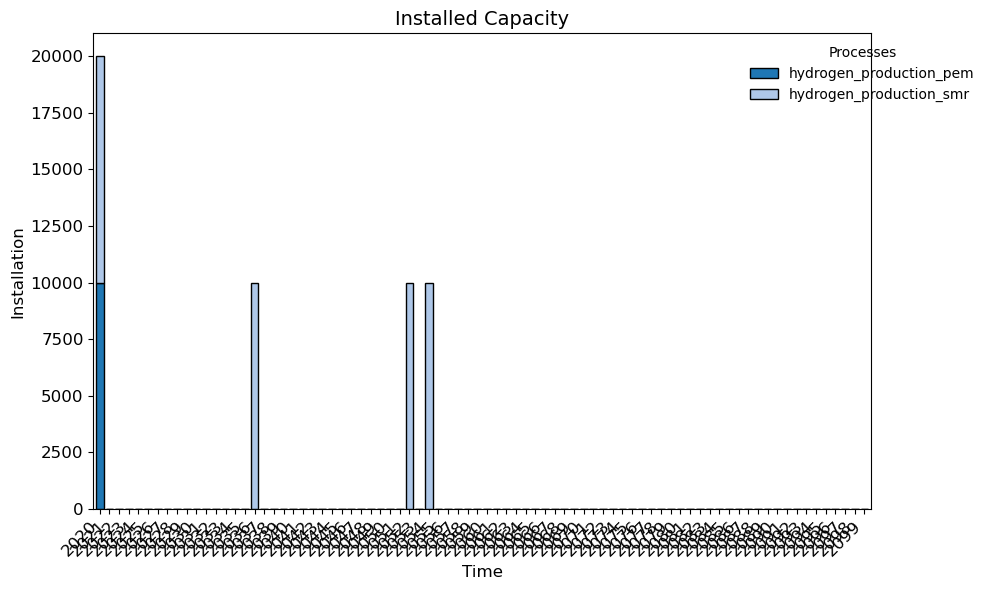

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Installed Capacity'}, xlabel='Time', ylabel='Installation'>)

In [37]:
pp.plot_installation()

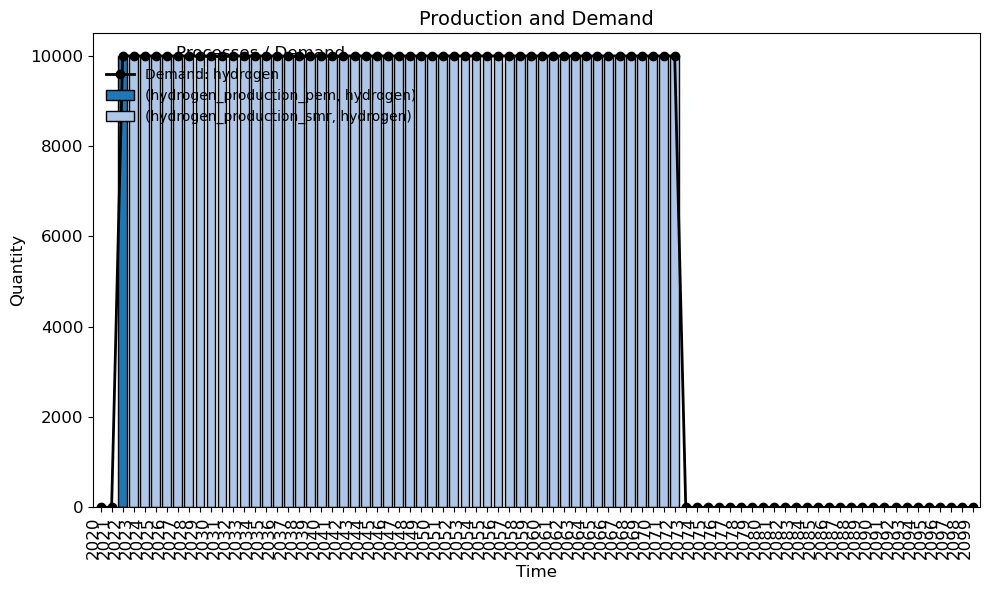

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Production and Demand'}, xlabel='Time', ylabel='Quantity'>)

In [39]:
pp.plot_production_and_demand()

In [30]:
pp.get_impacts()

Category      resource_depletion                          \
Process  hydrogen_production_pem hydrogen_production_smr   
Time                                                       
2020                    0.046745                0.000000   
2021                    0.046754                0.010588   
2022                    0.147275                0.010717   
2023                    0.000000                0.000906   
2024                    0.000000                0.000906   
...                          ...                     ...   
2095                    0.000000                0.000000   
2096                    0.000000                0.000000   
2097                    0.000000                0.000000   
2098                    0.000000                0.000000   
2099                    0.000000                0.000000   

Category          climate_change                          
Process  hydrogen_production_pem hydrogen_production_smr  
Time                                                      
2020                 2068.721390                0.000000  
2021                 1937.127657              320.916241  
2022                18944.474789              305.984635  
2023                    0.000000             6798.292093  
2024                    0.000000             6744.941154  
...                          ...                     ...  
2095                    0.000000                0.000000  
2096                    0.000000                0.000000  
2097                    0.000000                0.000000  
2098                    0.000000                0.000000  
2099                    0.000000                0.000000  

[80 rows x 4 columns]

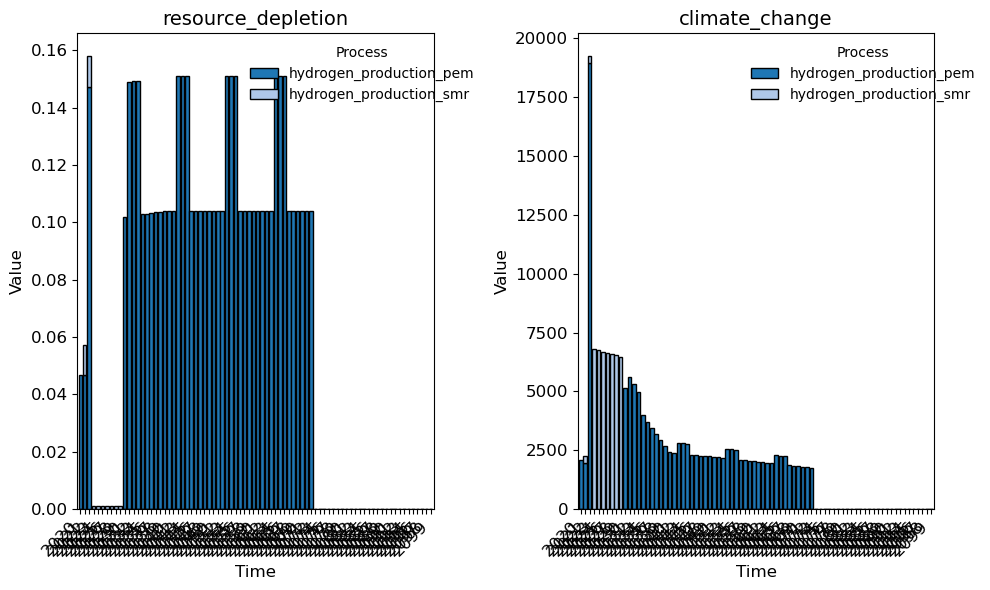

(<Figure size 1000x600 with 2 Axes>,
 array([<Axes: title={'center': 'resource_depletion'}, xlabel='Time', ylabel='Value'>,
        <Axes: title={'center': 'climate_change'}, xlabel='Time', ylabel='Value'>],
       dtype=object))

In [28]:
pp.plot_impacts()

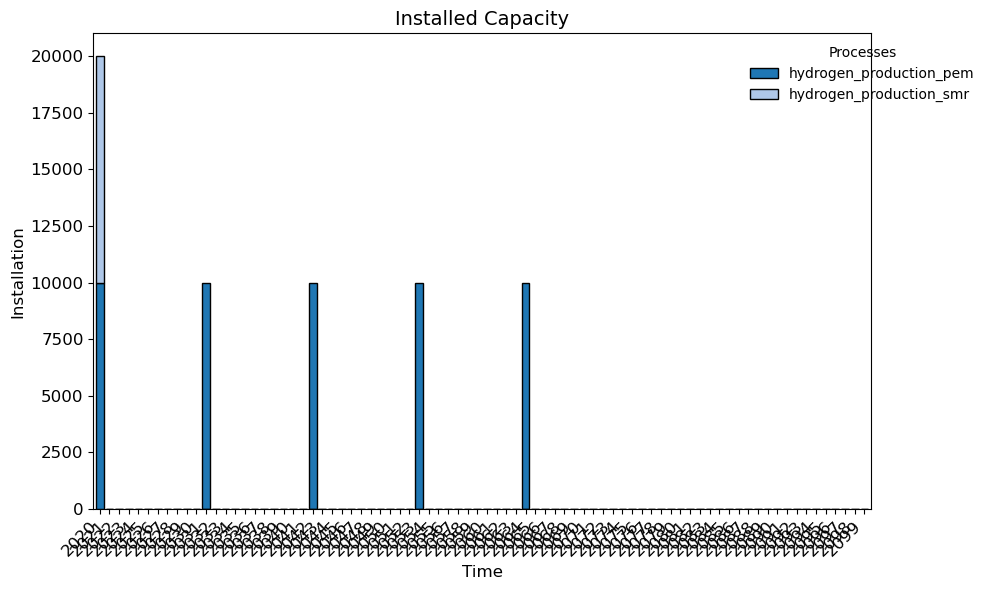

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Installed Capacity'}, xlabel='Time', ylabel='Installation'>)

In [29]:
pp.plot_installation()

opt land use

In [55]:
from optimex import optimizer

model = optimizer.create_model(
    optimization_model_inputs,
    name = "demo_simple_example",
    objective_category = "resource_depletion",
    flexible_operation = True, # Feel free to change this to see both
)

2025-06-13 13:01:23.075 | INFO     | optimex.optimizer:create_model:67 - Creating sets


2025-06-13 13:01:23.078 | INFO     | optimex.optimizer:create_model:109 - Creating parameters
2025-06-13 13:01:23.149 | INFO     | optimex.optimizer:create_model:272 - Creating variables


In [56]:
m, obj, results = optimizer.solve_model(model, solver_name="glpk", tee=False) # choose solver here, e.g. "gurobi", "cplex", "glpk", etc.

2025-06-13 13:01:28.843 | INFO     | optimex.optimizer:solve_model:601 - Solver [glpk] termination: optimal
2025-06-13 13:01:31.970 | INFO     | optimex.optimizer:solve_model:626 - Objective (scaled): 0.051816
2025-06-13 13:01:31.970 | INFO     | optimex.optimizer:solve_model:627 - Objective (real):   0.5647


In [82]:
import bw2calc as bc

In [83]:
lca = bc.LCA(
    demand={db_2020.get(name="hydrogen production, gaseous, 30 bar, from PEM electrolysis, from grid electricity", unit="kilogram"): 10000},
    method=(
                "EF v3.1 no LT",
                "material resources: metals/minerals no LT",
                "abiotic depletion potential (ADP): elements (ultimate reserves) no LT",
            ),
)

In [84]:
lca.lci()
lca.lcia()
print("Total impact:", lca.score)

Total impact: 2.534332848350403


/Users/timodiepers/anaconda3/envs/optimex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 3.13e+13)
  warnings.warn(msg, UmfpackWarning)


In [120]:
import pyomo.environ as pyo 
fg_scale = getattr(pp.m, "scales", {}).get("foreground", 1.0)
inventory = {
    (p, e, t): pyo.value(pp.m.scaled_inventory[p, e, t]) * fg_scale
    for p in pp.m.PROCESS
    for e in pp.m.ELEMENTARY_FLOW
    for t in pp.m.SYSTEM_TIME
}

import pandas as pd

dynamic_inventory_df = pd.DataFrame.from_records(
    [(p, e, t, v) for (p, e, t), v in inventory.items()],
    columns=["activity", "flow", "date", "amount"]
).astype({
    "activity": "str",
    "flow": "str",
    "date": "datetime64[s]",
    "amount": "float64"
})

In [121]:
dynamic_inventory_df["flow"] = dynamic_inventory_df["flow"].apply(
    lambda x: db_bio.get(code=x).id
)

In [122]:
from dynamic_characterization import characterize

df_characterized = characterize(
        dynamic_inventory_df,
        metric="radiative_forcing", # could also be GWP
        base_lcia_method=method,
        time_horizon=100,
)

2025-06-13 19:22:20.514 | INFO     | dynamic_characterization.dynamic_characterization:characterize:82 - No custom dynamic characterization functions provided. Using default dynamic             characterization functions. The flows that are characterized are based on the selection                of the initially chosen impact category.


<Axes: >

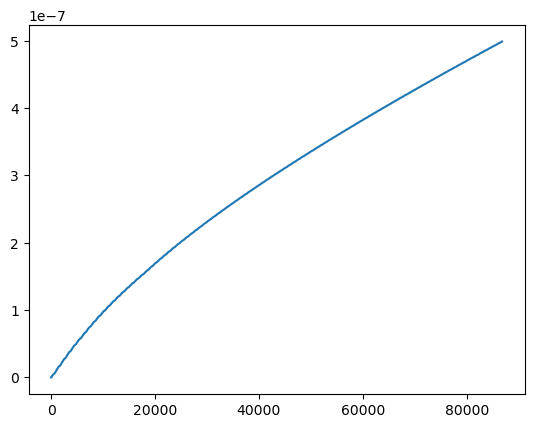

In [123]:
df_characterized.amount.cumsum().plot()

<Axes: >

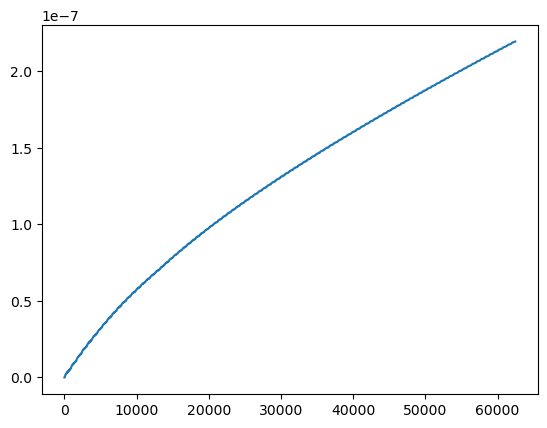

In [ ]:
df_characterized.amount.cumsum().plot()

In [75]:
import pandas as pd

inventory_df = pd.DataFrame.from_dict(inventory, orient='index', columns=['amount'])

In [ ]:
inventory_df

In [57]:
from optimex import postprocessing
pp = postprocessing.PostProcessor(m)

df_impact = pp.get_impacts()
df_impact

Category      resource_depletion                          \
Process  hydrogen_production_smr hydrogen_production_pem   
Time                                                       
2020                    0.000000                     0.0   
2021                    0.000000                     0.0   
2022                    0.171468                     0.0   
2023                    0.173528                     0.0   
2024                    0.000000                     0.0   
2025                    0.014503                     0.0   
2026                    0.014507                     0.0   
2027                    0.014510                     0.0   
2028                    0.014514                     0.0   
2029                    0.014517                     0.0   
2030                    0.014521                     0.0   
2031                    0.014564                     0.0   
2032                    0.014607                     0.0   
2033                    0.014650                     0.0   
2034                    0.014694                     0.0   
2035                    0.014737                     0.0   
2036                    0.014780                     0.0   
2037                    0.014823                     0.0   
2038                    0.014867                     0.0   
2039                    0.014910                     0.0   

Category          climate_change                          
Process  hydrogen_production_smr hydrogen_production_pem  
Time                                                      
2020                0.000000e+00                     0.0  
2021                0.000000e+00                     0.0  
2022                4.210835e-10                     0.0  
2023                4.006688e-10                     0.0  
2024                0.000000e+00                     0.0  
2025                9.207497e-09                     0.0  
2026                9.131335e-09                     0.0  
2027                9.055108e-09                     0.0  
2028                8.978811e-09                     0.0  
2029                8.902443e-09                     0.0  
2030                8.826000e-09                     0.0  
2031                8.753540e-09                     0.0  
2032                8.680933e-09                     0.0  
2033                8.608175e-09                     0.0  
2034                8.535262e-09                     0.0  
2035                8.462190e-09                     0.0  
2036                8.388956e-09                     0.0  
2037                8.315556e-09                     0.0  
2038                8.241985e-09                     0.0  
2039                8.168240e-09                     0.0

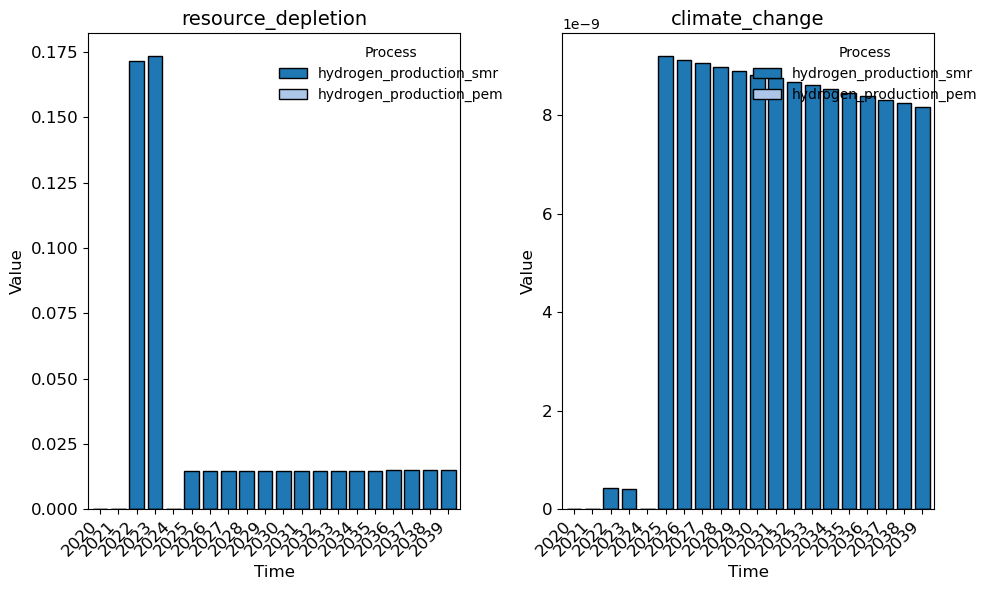

(<Figure size 1000x600 with 2 Axes>,
 array([<Axes: title={'center': 'resource_depletion'}, xlabel='Time', ylabel='Value'>,
        <Axes: title={'center': 'climate_change'}, xlabel='Time', ylabel='Value'>],
       dtype=object))

In [58]:
pp.plot_impacts()